# Objectifs et motivations

Dans ce notebook, nous allons créer nos premiers modèles explicatifs afin de d'obtenir une baseline avant de procéder à une étape de création de nouvelles variables. La comparaison des résultats obtenus à l'aide de ces modèles reposant sur l'exploitation brute des attributs de la base de données et ceux obtenus en créant de nouvelle features nous permettra d'évaluer l'intérêt et la pertinance de ces features.  
  
Rappellons que notre objectif est de prédire le temps d'un match de tennis à partir des données historiques des matchs joué entre 2000 et 2019. 

In [288]:
import os 
import string
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [289]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [290]:
pd.set_option('display.max_columns', 500)
sns.set_style("ticks")

In [291]:
def perc_print(a, b):
    return round((a-b)/a*100)

In [292]:
PATH = os.path.abspath('')

In [293]:
data = pd.read_csv(PATH+'/data/Données_nettoyées.csv', index_col=0)

In [294]:
data

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,2010-339,Brisbane,Hard,32,A,2010-01-03,1,104053,Andy Roddick,R,188.0,USA,27.348392,103429,Peter Luczak,R,183.0,AUS,30.346338,7-6(5) 6-2,3,R32,84.0,15.0,0.0,63.0,42.0,36.0,14.0,10.0,3.0,3.0,4.0,2.0,56.0,34.0,29.0,11.0,10.0,3.0,5.0,7.0,4410.0,77.0,598.0,2010
1,2010-339,Brisbane,Hard,32,A,2010-01-03,2,104958,Carsten Ball,L,198.0,AUS,22.543463,104999,Mischa Zverev,L,190.0,GER,22.370979,7-5 6-1,3,R32,70.0,10.0,3.0,57.0,30.0,23.0,19.0,10.0,0.0,0.0,2.0,2.0,66.0,34.0,22.0,14.0,9.0,7.0,10.0,134.0,400.0,78.0,590.0,2010
2,2010-339,Brisbane,Hard,32,A,2010-01-03,3,104755,Richard Gasquet,R,185.0,FRA,23.548255,103813,Jarkko Nieminen,L,185.0,FIN,28.451745,6-3 4-6 6-4,3,R32,121.0,5.0,4.0,97.0,51.0,33.0,27.0,15.0,5.0,8.0,4.0,0.0,85.0,58.0,38.0,14.0,14.0,7.0,11.0,52.0,850.0,88.0,568.0,2010
3,2010-339,Brisbane,Hard,32,A,2010-01-03,4,105051,Matthew Ebden,R,188.0,AUS,22.108145,103781,Jurgen Melzer,L,183.0,AUT,28.621492,7-5 6-1,3,R32,64.0,12.0,1.0,50.0,35.0,30.0,12.0,10.0,3.0,3.0,2.0,1.0,53.0,29.0,16.0,15.0,9.0,2.0,5.0,285.0,151.0,28.0,1260.0,2010
4,2010-339,Brisbane,Hard,32,A,2010-01-03,5,104607,Tomas Berdych,R,196.0,CZE,24.298426,105194,Nick Lindahl,R,183.0,AUS,21.429158,6-2 6-4,3,R32,69.0,3.0,1.0,46.0,27.0,24.0,14.0,9.0,1.0,1.0,6.0,1.0,69.0,41.0,26.0,14.0,9.0,6.0,9.0,20.0,1655.0,251.0,179.0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64517,2019-0605,Tour Finals,Hard,8,F,2019-11-11,290,106233,Dominic Thiem,R,185.0,AUT,26.187543,104925,Novak Djokovic,R,188.0,SRB,32.473648,6-7(5) 6-3 7-6(5),3,RR,167.0,6.0,4.0,125.0,71.0,48.0,28.0,17.0,6.0,9.0,9.0,3.0,93.0,58.0,42.0,17.0,16.0,0.0,4.0,5.0,5025.0,2.0,8945.0,2019
64518,2019-0605,Tour Finals,Hard,8,F,2019-11-11,289,104925,Novak Djokovic,R,188.0,SRB,32.473648,126610,Matteo Berrettini,R,NaN,ITA,23.581109,6-2 6-1,3,RR,63.0,4.0,1.0,40.0,24.0,18.0,12.0,8.0,0.0,1.0,4.0,2.0,48.0,34.0,16.0,4.0,7.0,2.0,7.0,2.0,8945.0,8.0,2670.0,2019
64519,2019-0605,Tour Finals,Hard,8,F,2019-11-11,288,106233,Dominic Thiem,R,185.0,AUT,26.187543,103819,Roger Federer,R,185.0,SUI,38.258727,7-5 7-5,3,RR,100.0,1.0,1.0,81.0,51.0,33.0,19.0,12.0,3.0,4.0,5.0,0.0,68.0,47.0,33.0,10.0,12.0,2.0,5.0,5.0,5025.0,3.0,6190.0,2019
64520,2019-0605,Tour Finals,Hard,8,F,2019-11-11,287,103819,Roger Federer,R,185.0,SUI,38.258727,126610,Matteo Berrettini,R,NaN,ITA,23.581109,7-6(2) 6-3,3,RR,78.0,8.0,0.0,67.0,45.0,35.0,15.0,10.0,3.0,3.0,6.0,1.0,63.0,44.0,31.0,10.0,11.0,2.0,4.0,3.0,6190.0,8.0,2670.0,2019


# Modèles de base

Nous allons présenter dans ce notebook une première série de modèles basés sur l'exploitation des attributs contenus dans notre base de données afin d'analyser les résultats obtenus par ce biais avant de complexifier le modèle en procédant à une phase de création de features.  
Ces résultats serviront de baseline par la suite afin de juger de la qualité des modèles qui le suivront. La mesure de qualité du modèle choisi sera la Mean Squared Error (MSE).  

La plupart de nos variables sont des statistiques concernant directement le match et ne sont donc pas utilisables dans le cadre d'une prédiction. Ces variables devront être aggrégés avant d'être utilisable pour caractériser un joueur. 
  
Les différentes opérations effectuées sont :
- Création d'une base d'appprentissage et de validation et séparation des attributs du phénomène à expliquer
- Traitement des variables catégorielles
- Régression Linéaire
- Régression Lasso
- Régression Polynomiale (déjà une création de features... à voir)
- Arbre de Décisions
- Random Forest
- Adaboost

## Création d'une base d'appprentissage et de validation et séparation des attributs du phénomène à expliquer

La base d'apprentissage et de validation est crée à l'aide de la fonction `train_test_split`. Nous prenons 1/3 de notre échantillon pour construire la base de validation.

In [295]:
from sklearn.model_selection import train_test_split

In [296]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('minutes', axis=1), data['minutes'], test_size=0.33, random_state=42)
print("Taille de l'échantillon d'apprentissage : {}\nTaille de l'échantillon de validation : {}".format(X_train.shape[0], X_test.shape[0]))

Taille de l'échantillon d'apprentissage : 36525
Taille de l'échantillon de validation : 17990


Deux types d'attributs sont supprimés :
1. les attributs directement liées au match (w_ace le nombre d'ace du gagnant, l_bpSaved le nombre de balles de match sauvées par le perdant, etc...)
2. les attributs d'identification (tourney_id, winner_id, etc...)

Seuls sont gardés les attributs n'étant pas directement liée au match et ayant un potentiel.

In [297]:
print("Nombre d'attributs initiaux : {}".format(X_train.shape[1]))

Nombre d'attributs initiaux : 45


In [298]:
liste_attributs = ['tourney_name', 
                   'tourney_level',
                   'surface',
                   'winner_hand',
                   'winner_ht', 
                   'winner_age',
                   'winner_rank',
                   'loser_hand', 
                   'loser_ht', 
                   'loser_age',
                   'loser_rank',
                   'best_of',
                   'round',
                   'year']

In [299]:
X_train , X_test = X_train[liste_attributs] , X_test[liste_attributs]
print("Nombre d'attributs après sélection : {}".format(X_train.shape[1]))

Nombre d'attributs après sélection : 14


## Traitement des variables catégorielles et supression des valeurs manquantes

Nous commençons par répérer les variables catégorielles avant d'observer le nombre de modalitées qu'elles prennent.

In [300]:
X_qual = ['tourney_name', 'surface', 'tourney_level', 'round', 'winner_hand', 'loser_hand']
for attribut in X_qual:
    print(attribut, ':', pd.get_dummies(data[attribut]).shape[1])

tourney_name : 126
surface : 4
tourney_level : 4
round : 10
winner_hand : 3
loser_hand : 3


L'attribut _tourney_name_ prend 126 modalités. La matrice étant trop sparse nous l'ignorons pour le moment, et cette dernière sera ré-intégrées lors d'une régression régularisée.  
Les autres attributs qualitatifs seront retraités de manière à ce que chaque modalité soit encodée par une dummy, en prenant garde au problème de multicolinéarité en utilisant l'option `drop_first=True` de la fonction `get_dummies`.

In [301]:
X_qual.remove('tourney_name')
X_train_LM = X_train.drop('tourney_name', axis=1)
X_test_LM = X_test.drop('tourney_name', axis=1)

In [302]:
for X in [X_train_LM, X_test_LM]:
    for variable in X_qual:
        var_enc = pd.get_dummies(X[variable], prefix=variable, drop_first=True)
        X.drop(variable, axis=1, inplace=True)
        for col_enc in var_enc.columns:
            X[col_enc] = var_enc[col_enc]

Finalement, nous supprimons les variables manques.

In [303]:
for attribut in X_train_LM.columns:
    print('{} : test = {} NA / train = {} NA'.format(attribut, X_train_LM[attribut].isna().sum(), X_test_LM[attribut].isna().sum()))

winner_ht : test = 1949 NA / train = 962 NA
winner_age : test = 0 NA / train = 0 NA
winner_rank : test = 13 NA / train = 9 NA
loser_ht : test = 3075 NA / train = 1518 NA
loser_age : test = 0 NA / train = 0 NA
loser_rank : test = 88 NA / train = 47 NA
best_of : test = 0 NA / train = 0 NA
year : test = 0 NA / train = 0 NA
surface_Clay : test = 0 NA / train = 0 NA
surface_Grass : test = 0 NA / train = 0 NA
surface_Hard : test = 0 NA / train = 0 NA
tourney_level_F : test = 0 NA / train = 0 NA
tourney_level_G : test = 0 NA / train = 0 NA
tourney_level_M : test = 0 NA / train = 0 NA
round_ER : test = 0 NA / train = 0 NA
round_F : test = 0 NA / train = 0 NA
round_QF : test = 0 NA / train = 0 NA
round_R128 : test = 0 NA / train = 0 NA
round_R16 : test = 0 NA / train = 0 NA
round_R32 : test = 0 NA / train = 0 NA
round_R64 : test = 0 NA / train = 0 NA
round_RR : test = 0 NA / train = 0 NA
round_SF : test = 0 NA / train = 0 NA
winner_hand_R : test = 0 NA / train = 0 NA
winner_hand_U : test = 0 NA

Les attributs _winner_ht_ et _loser_ht_ ayant trop de valeurs manquantes, nous supprimons ces deux colonnes et retirons les observations contenant d'autres valeurs manquantes sur les autres attributs.

In [304]:
X_train_LM = X_train_LM.drop(['winner_ht', 'loser_ht'], axis=1)
X_test_LM = X_test_LM.drop(['winner_ht', 'loser_ht'], axis=1)

In [305]:
X_train_LM.dropna(axis=0, how='any', inplace=True)
X_test_LM.dropna(axis=0, how='any', inplace=True)
y_train = y_train[X_train_LM.index]
y_test = y_test[X_test_LM.index]

## Régression Linéaire

Nous utilisons finalement la fonction `LinearRegression` en notant que l'intercept est mise par défaut par la fonction (et la gestion de la multicolinéarité est également gérée par défaut par la fonction).  
Nous importons la fonction `mean_squared_error` afin de calculer la MSE.

In [306]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Entrainement du modèle.

In [307]:
regLM = LinearRegression().fit(X_train_LM.values, y_train.values)

Notre échantillon de validation ne contenant pas de modalité _round_ER_ nous la créons de manière artificielle (`np.zeros`) afin d'avoir le format requis pour prédire en utilisant notre modèle _regLM_.

In [308]:
y_pred_train = regLM.predict(X_train_LM.values)
y_pred_test = regLM.predict(X_test_LM.values)
print('MSE : train = {} / test = {}'.format(mean_squared_error(y_train.values, y_pred_train), mean_squared_error(y_test.values, y_pred_test)))

MSE : train = 1093.3083732046387 / test = 1111.969709211426


In [309]:
coefficients = pd.concat([pd.DataFrame(X_train_LM.columns),pd.DataFrame(np.transpose(regLM.coef_))], axis = 1)
coefficients

,0,0
0,winner_age,0.159432
1,winner_rank,0.034677
2,loser_age,0.026060
3,loser_rank,-0.025929
4,best_of,30.259647
5,year,0.410208
6,surface_Clay,3.771150
7,surface_Grass,-4.606503
8,surface_Hard,0.636774
9,tourney_level_F,4.211414


Une analyse rapide des coefficients de nos variables explicatives nous montre clairement le faible pouvoir explicatif de la durée d'un match de la plupart de nos variables.

On voit que la variable _best_of_ joue un rôle prépondérant dans la détermination de la longueur d'un match, comme nous pouvions nous y attendre suite à notre analyse descriptive des données.  
  
L'utilisation de cette variable ajoute une grand part d'explicativité dans notre modèle mais cependant, une visualisation de nos résultats montre clairement que deux catégories de match se distinguent. L'intuition nous amène à penser que ces deux clusters sont uniquement définis par l'attribut _best_of_, ce que nous vérifions sur nos deux échantillons train et test.

In [310]:
X_train_LM_bo3 = X_train_LM[X_train_LM['best_of']==3].copy()
X_train_LM_bo5 = X_train_LM[X_train_LM['best_of']==5].copy()
y_train_bo3 = y_train[X_train_LM_bo3.index]
y_train_bo5 = y_train[X_train_LM_bo5.index]
X_test_LM_bo3 = X_test_LM[X_test_LM['best_of']==3].copy()
X_test_LM_bo5 = X_test_LM[X_test_LM['best_of']==5].copy()
y_test_bo3 = y_test[X_test_LM_bo3.index]
y_test_bo5 = y_test[X_test_LM_bo5.index]

In [311]:
y_pred_train_bo3 = regLM.predict(X_train_LM_bo3.values)
y_pred_train_bo5 = regLM.predict(X_train_LM_bo5.values)
y_pred_test_bo3 = regLM.predict(X_test_LM_bo3.values)
y_pred_test_bo5 = regLM.predict(X_test_LM_bo5.values)

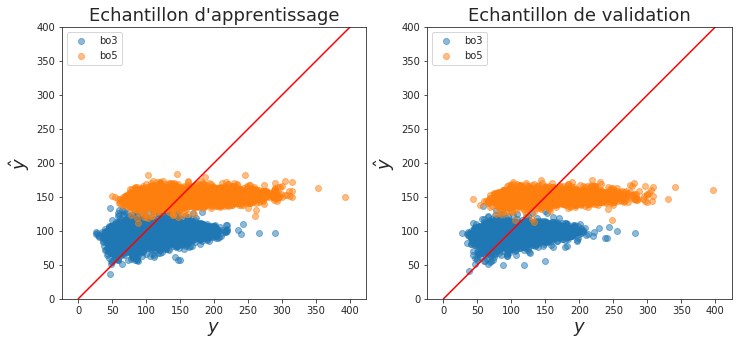

In [312]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].scatter(y_train_bo3.values, y_pred_train_bo3, alpha=0.5, label='bo3')
axs[0].scatter(y_train_bo5.values, y_pred_train_bo5, alpha=0.5, label='bo5')
axs[0].plot([0,400], [0,400], color='red')
axs[0].axis('equal')
axs[0].set_xlim((0,400))
axs[0].set_ylim((0,400))
axs[0].set_xlabel("$y$",fontsize=18)
axs[0].set_ylabel("$\hat{y}$",fontsize=18)
axs[0].legend()
axs[0].set_title("Echantillon d'apprentissage",fontsize=18)
axs[1].scatter(y_test_bo3.values, y_pred_test_bo3, alpha=0.5, label='bo3')
axs[1].scatter(y_test_bo5.values, y_pred_test_bo5, alpha=0.5, label='bo5')
axs[1].plot([0,400], [0,400], color='red')
axs[1].axis('equal')
axs[1].set_xlim((0,400))
axs[1].set_ylim((0,400))
axs[1].set_xlabel("$y$",fontsize=18)
axs[1].set_ylabel("$\hat{y}$",fontsize=18)
axs[1].legend()
axs[1].set_title("Echantillon de validation", fontsize=18)
plt.show()

A partir de ce résultat, nous décidons créer des modèles spécifiques aux Bo3 et aux Bo5 (_best_of_ 3 et _best_of_ 5). Ces résultats serviront de baseline par la suite.

In [313]:
X_train_LM_bo3.drop('best_of', axis=1, inplace=True)
X_train_LM_bo5.drop('best_of', axis=1, inplace=True)
X_test_LM_bo3.drop('best_of', axis=1, inplace=True)
X_test_LM_bo5.drop('best_of', axis=1, inplace=True)

In [314]:
regLM_bo3 = LinearRegression().fit(X_train_LM_bo3.values, y_train_bo3.values)

y_pred_train_bo3 = regLM_bo3.predict(X_train_LM_bo3.values)
y_pred_test_bo3 = regLM_bo3.predict(X_test_LM_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

regLM_bo5 = LinearRegression().fit(X_train_LM_bo5.values, y_train_bo5.values)

y_pred_train_bo5 = regLM_bo5.predict(X_train_LM_bo5.values)
y_pred_test_bo5 = regLM_bo5.predict(X_test_LM_bo5.values)
print('Bo5:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Bo3:
	MSE : train = 874.2014996597163 / test = 878.376118735762
Bo5:
	MSE : train = 2029.0861222567046 / test = 2134.7396644578503


## Régression Lasso (Least Absolute Shrinkage and Selection Operator)

Afin de réaliser une sélection parcimonieuse de nos variables, nous effectuons une régression Lasso, qui, contrairement à la régression Ridge, permet d'assigner la valeur des coefficients exactement à zéro, et ainsi éliminer les variables non pertinentes.

In [315]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [316]:
regLasso = Lasso(max_iter=100000, tol=0.1)

La régression Lasso comprend un coefficient de pénalité $\alpha$ qu'il est nécessaire d'optimiser par cross-validation. Pour ce faire, nous utilisons la fonction `GridSearchCV` sur le vecteur de valeurs à tester de $\alpha$ _lasso_params_. Une fois encore, la métrique utilisée reste la MSE (pour être précis nous utilisons la _neg_mean_squared_error_ dans le cadre d'une maximisation).

In [317]:
lasso_params = {'alpha':[1e-15, 1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10]}

In [318]:
GSCV_lasso_bo3 = GridSearchCV(regLasso, lasso_params, 'neg_mean_squared_error', cv=3)

In [319]:
GSCV_lasso_bo3.fit(X_train_LM_bo3, y_train_bo3)

/home/cesar/.anaconda3/envs/projetml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8621871.840644002, tolerance: 1783698.2773782434
  positive)
/home/cesar/.anaconda3/envs/projetml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8743963.748218726, tolerance: 1805185.2893440542
  positive)
/home/cesar/.anaconda3/envs/projetml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2127346.8078001775, tolerance: 1783698.2773782434
  positive)
/home/cesar/.anaconda3/envs/projetml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning

GridSearchCV(cv=3, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=100000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.1, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1, 1, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

<font>Malgrès l'augmentation de la tolérence du modèle et du nombre d'itérations effectuées, la convergence de notre modèle n'est pas atteinte pour les faibles valeurs de $\alpha = \{10^{-15}, 10^{-10}\}$.</font>

In [320]:
regBestLasso_bo3 = GSCV_lasso_bo3.best_estimator_
print('Valeur optimale de alpha : {}'.format(regBestLasso_bo3.get_params()['alpha']))

Valeur optimale de alpha : 0.01


In [321]:
y_pred_train_bo3 = regBestLasso_bo3.predict(X_train_LM_bo3.values)
y_pred_test_bo3 = regBestLasso_bo3.predict(X_test_LM_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

Bo3:
	MSE : train = 874.3968109472883 / test = 878.205604805397


In [322]:
GSCV_lasso_bo5 = GridSearchCV(regLasso, lasso_params, 'neg_mean_squared_error', cv=3)
GSCV_lasso_bo5.fit(X_train_LM_bo5, y_train_bo5)
regBestLasso_bo5 = GSCV_lasso_bo5.best_estimator_
print('Valeur optimale de alpha : {}'.format(regBestLasso_bo5.get_params()['alpha']))
y_pred_train_bo5 = regBestLasso_bo5.predict(X_train_LM_bo5.values)
y_pred_test_bo5 = regBestLasso_bo5.predict(X_test_LM_bo5.values)
print('Bo5:\n\tMSE : test = {} / train = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

/home/cesar/.anaconda3/envs/projetml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4492676.533528834, tolerance: 965189.3884675095
  positive)
/home/cesar/.anaconda3/envs/projetml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4523124.3230801355, tolerance: 983492.9127272727
  positive)
/home/cesar/.anaconda3/envs/projetml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2068669.1561955297, tolerance: 965189.3884675095
  positive)
/home/cesar/.anaconda3/envs/projetml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: 

Valeur optimale de alpha : 0.1
Bo5:
	MSE : test = 2033.2021199068909 / train = 2132.0859878795745


la valeur optimale trouvée par validation croisée sur notre base d'apprentissage est :
- $\alpha=0.01$ pour les Bo3
- $\alpha=0.1$ pour les Bo5

Nous procédons à partir de ces résultats à une seconde GridSearch plus fine centrée autour de ces valeurs. 

In [323]:
lasso_params_centre_bo3 = {'alpha':[0.01-(x*0.001) for x in range(-10, 10)]}
lasso_params_centre_bo5 = {'alpha':[0.1-(x*0.01) for x in range(-10, 10)]}

In [324]:
GSCV_lasso_bo3 = GridSearchCV(regLasso, lasso_params_centre_bo3, 'neg_mean_squared_error', cv=3)
GSCV_lasso_bo3.fit(X_train_LM_bo3, y_train_bo3)
regBestLasso_bo3 = GSCV_lasso_bo3.best_estimator_
print('Valeur optimale de alpha : {}'.format(regBestLasso_bo3.get_params()['alpha']))
y_pred_train_bo3 = regBestLasso_bo3.predict(X_train_LM_bo3.values)
y_pred_test_bo3 = regBestLasso_bo3.predict(X_test_LM_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

GSCV_lasso_bo5 = GridSearchCV(regLasso, lasso_params_centre_bo5, 'neg_mean_squared_error', cv=3)
GSCV_lasso_bo5.fit(X_train_LM_bo5, y_train_bo5)
regBestLasso_bo5 = GSCV_lasso_bo5.best_estimator_
print('Valeur optimale de alpha : {}'.format(regBestLasso_bo5.get_params()['alpha']))
y_pred_train_bo5 = regBestLasso_bo5.predict(X_train_LM_bo5.values)
y_pred_test_bo5 = regBestLasso_bo5.predict(X_test_LM_bo5.values)
print('Bo5:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Valeur optimale de alpha : 0.006
Bo3:
	MSE : train = 874.2849347309084 / test = 878.2651282904138
Valeur optimale de alpha : 0.05
Bo5:
	MSE : train = 2031.4714876419537 / test = 2132.3401682790513


Nous gardons à partir d'ici ces valeurs pour nos coefficients de pénalisation: 
- $\alpha_{Bo3}^*=0.006$
- $\alpha_{Bo5}^*=0.05$

In [325]:
regLasso_bo3 = Lasso(alpha=0.006, max_iter=100000, tol=0.01).fit(X_train_LM_bo3, y_train_bo3)
regLasso_bo5 = Lasso(alpha=0.05, max_iter=100000, tol=0.01).fit(X_train_LM_bo5, y_train_bo5)

Analyse des coefficients éliminés par la régularisation L1 pour le modèle bo3.

In [326]:
print('Coeffcients retenus dans le modèle Bo3:\n')
for var, coef in zip(X_train_LM_bo3.columns, regLasso_bo3.coef_):
    if coef != 0:
        print('Coefficient {} = {}'.format(var, coef))
print('\nCoeffcients éliminés dans le modèle Bo3:\n')
for var, coef in zip(X_train_LM_bo3.columns, regLasso_bo3.coef_):
    if coef == 0:
        print('Coefficient {} = {}'.format(var, coef))

Coeffcients retenus dans le modèle Bo3:

Coefficient winner_age = 0.1340521534574075
Coefficient winner_rank = 0.0258250742716789
Coefficient loser_age = 0.016700086689570712
Coefficient loser_rank = -0.021957491093647176
Coefficient year = 0.39325546603027955
Coefficient surface_Clay = 3.6714703041746795
Coefficient surface_Grass = -4.134058008426745
Coefficient surface_Hard = 0.09660277045072328
Coefficient tourney_level_F = 4.286187502940848
Coefficient tourney_level_M = 4.011019106171934
Coefficient round_ER = -10.488230480023987
Coefficient round_F = 7.552185827300331
Coefficient round_QF = 1.351080085486725
Coefficient round_R128 = -2.3383477597171365
Coefficient round_R32 = -1.9812140009651649
Coefficient round_R64 = -3.7559503360218596
Coefficient round_RR = 0.9874800389298175
Coefficient round_SF = 4.2839071553674
Coefficient winner_hand_R = -1.2748359731751802
Coefficient loser_hand_R = 0.5732706885470799

Coeffcients éliminés dans le modèle Bo3:

Coefficient tourney_level_G 

Analyse des coefficients éliminés par la régularisation L1 pour le modèle bo5.

In [327]:
print('Coeffcients retenus dans le modèle Bo5:\n')
for var, coef in zip(X_train_LM_bo5.columns, regLasso_bo5.coef_):
    if coef != 0:
        print('Coefficient {} = {}'.format(var, coef))
print('\nCoeffcients éliminés dans le modèle Bo5:\n')
for var, coef in zip(X_train_LM_bo5.columns, regLasso_bo5.coef_):
    if coef == 0:
        print('Coefficient {} = {}'.format(var, coef))

Coeffcients retenus dans le modèle Bo5:

Coefficient winner_age = 0.24450945266909568
Coefficient winner_rank = 0.07377345810171246
Coefficient loser_age = 0.036279703601194
Coefficient loser_rank = -0.05180491006702161
Coefficient year = 0.5414882419920235
Coefficient surface_Clay = 1.7380641437628086
Coefficient surface_Grass = -6.995186817104105
Coefficient round_F = 11.052780646172902
Coefficient round_QF = 1.4175206834182519
Coefficient round_R128 = -11.385489001482515
Coefficient round_R32 = -5.035608699067203
Coefficient round_R64 = -7.563460787399991
Coefficient round_SF = 8.50265815878292
Coefficient winner_hand_R = -2.0451806137821853
Coefficient loser_hand_R = 3.3635534017578785
Coefficient loser_hand_U = 1.3165120454760701

Coeffcients éliminés dans le modèle Bo5:

Coefficient surface_Hard = 0.0
Coefficient tourney_level_F = -0.0
Coefficient tourney_level_G = 0.0
Coefficient tourney_level_M = 0.0
Coefficient round_ER = 0.0
Coefficient round_R16 = 0.0
Coefficient round_RR = 

Le coefficient de pénalisation $\alpha$ étant plus élevé dans le modèle Bo5, plus de variables sont éliminées. Cependant, nous retrouvons des concordances dans la liste des variables éliminées : les variables _round_RR_, _tourney_level_G_ et _winner_hand_U_ sont éliminées dans les deux modèles.
  
Le modèle bo5 élimine un plus grand nombre de variables, et parmis ces variables contraites à zéro, nous remarquons que toutes les modalités de la variable _tourney_level_ sont concernées, ce qui témoigne du faible pouvoir explicatif de cet attribut dans un Bo5.
  
Nous retirons donc cet attribut dans notre base Bo5.

In [328]:
X_train_LM_bo5.drop(['tourney_level_M', 'tourney_level_G', 'tourney_level_F'], axis=1, inplace=True)

Maintenant que nous avons fixé la valeur de $\alpha$ nous réintégrons la variable _tourney_name_ pour voir les modalités (nom du tournoi) comportant un pouvoir explicatif.

In [329]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('minutes', axis=1), data['minutes'], test_size=0.33, random_state=42)
X_train , X_test = X_train[liste_attributs] , X_test[liste_attributs]

X_train_LM = X_train.copy()
X_test_LM = X_test.copy()

# Cette fois nous laissons tourney_name dans X_qual
X_qual = ['tourney_name', 'surface', 'tourney_level', 'round', 'winner_hand', 'loser_hand']
for X in [X_train_LM, X_test_LM]:
    for variable in X_qual:
        var_enc = pd.get_dummies(X[variable], prefix=variable, drop_first=True)
        X.drop(variable, axis=1, inplace=True)
        for col_enc in var_enc.columns:
            X[col_enc] = var_enc[col_enc]
X_train_LM = X_train_LM.drop(['winner_ht', 'loser_ht'], axis=1)
X_test_LM = X_test_LM.drop(['winner_ht', 'loser_ht'], axis=1)

X_train_LM.dropna(axis=0, how='any', inplace=True)
X_test_LM.dropna(axis=0, how='any', inplace=True)
y_train = y_train[X_train_LM.index]
y_test = y_test[X_test_LM.index]

X_train_LM_bo3 = X_train_LM[X_train_LM['best_of']==3].copy()
X_train_LM_bo5 = X_train_LM[X_train_LM['best_of']==5].copy()
y_train_bo3 = y_train[X_train_LM_bo3.index]
y_train_bo5 = y_train[X_train_LM_bo5.index]
X_test_LM_bo3 = X_test_LM[X_test_LM['best_of']==3].copy()
X_test_LM_bo5 = X_test_LM[X_test_LM['best_of']==5].copy()
y_test_bo3 = y_test[X_test_LM_bo3.index]
y_test_bo5 = y_test[X_test_LM_bo5.index]

X_train_LM_bo3.drop('best_of', axis=1, inplace=True)
X_train_LM_bo5.drop('best_of', axis=1, inplace=True)
X_test_LM_bo3.drop('best_of', axis=1, inplace=True)
X_test_LM_bo5.drop('best_of', axis=1, inplace=True)

X_train_LM_bo5.drop(['tourney_level_M', 'tourney_level_G', 'tourney_level_F'], axis=1, inplace=True)

In [330]:
regLasso_bo3 = Lasso(alpha=0.006, max_iter=100000, tol=0.1).fit(X_train_LM_bo3, y_train_bo3)
regLasso_bo5 = Lasso(alpha=0.05, max_iter=100000, tol=0.1).fit(X_train_LM_bo5, y_train_bo5)

In [331]:
tournois_retenus_bo3 = []
print('Tournois retenus dans le modèle Bo3:\n')
for var, coef in zip(X_train_LM_bo3.columns, regLasso_bo3.coef_):
    if var[:12] == 'tourney_name':
        if coef != 0:
            print('Tournoi {} = {}'.format(var, coef))
            tournois_retenus_bo3.append(var)
print('\nTournois éliminés dans le modèle Bo3:\n')
for var, coef in zip(X_train_LM_bo3.columns, regLasso_bo3.coef_):
    if var[:12] == 'tourney_name':
        if coef == 0:
            print('Tournoi {} = {}'.format(var, coef))

Tournois retenus dans le modèle Bo3:

Tournoi tourney_name_Acapulco = 2.8976415796057156
Tournoi tourney_name_Adelaide = -2.498997899598375
Tournoi tourney_name_Amersfoort = -3.136626176325421
Tournoi tourney_name_Antwerp = -1.6873615902421115
Tournoi tourney_name_Atlanta = 0.269838125000823
Tournoi tourney_name_Auckland = -3.488054920903913
Tournoi tourney_name_Bangkok = -0.031482415717018125
Tournoi tourney_name_Basel = -0.746535908725921
Tournoi tourney_name_Bastad = -3.445300865954128
Tournoi tourney_name_Beijing = 0.5991933534016295
Tournoi tourney_name_Beijing Olympics = 4.218309074644751
Tournoi tourney_name_Belgrade = 2.073881299701207
Tournoi tourney_name_Bogota = -2.4027631671302507
Tournoi tourney_name_Brisbane = 0.8761976160931098
Tournoi tourney_name_Buenos Aires = 4.286808628523434
Tournoi tourney_name_Canada Masters = 3.150950902288256
Tournoi tourney_name_Casablanca = -0.04383018591229902
Tournoi tourney_name_Chennai = -1.3116537893078122
Tournoi tourney_name_Cincinnati

In [332]:
tournois_retenus_bo5 = []
print('Tournois retenus dans le modèle Bo5:\n')
for var, coef in zip(X_train_LM_bo5.columns, regLasso_bo5.coef_):
    if var[:12] == 'tourney_name':
        if coef != 0:
            print('Tournoi {} = {}'.format(var, coef))
            tournois_retenus_bo5.append(var)
print('\nTournois éliminés dans le modèle Bo5:\n')
for var, coef in zip(X_train_LM_bo5.columns, regLasso_bo5.coef_):
    if var[:12] == 'tourney_name':
        if coef == 0:
            print('Tournoi {} = {}'.format(var, coef))

Tournois retenus dans le modèle Bo5:

Tournoi tourney_name_Australian Open = 0.23944818119176525
Tournoi tourney_name_Roland Garros = 1.917680456287987
Tournoi tourney_name_US Open = 1.3607738713463284
Tournoi tourney_name_Wimbledon = -6.233613420032386

Tournois éliminés dans le modèle Bo5:

Tournoi tourney_name_ATP Next Gen Finals = 0.0
Tournoi tourney_name_Acapulco = 0.0
Tournoi tourney_name_Adelaide = 0.0
Tournoi tourney_name_Amersfoort = -0.0
Tournoi tourney_name_Amsterdam = 0.0
Tournoi tourney_name_Antalya = 0.0
Tournoi tourney_name_Antwerp = 0.0
Tournoi tourney_name_Atlanta = 0.0
Tournoi tourney_name_Auckland = 0.0
Tournoi tourney_name_Bangkok = 0.0
Tournoi tourney_name_Barcelona = 0.0
Tournoi tourney_name_Basel = -0.0
Tournoi tourney_name_Bastad = 0.0
Tournoi tourney_name_Beijing = 0.0
Tournoi tourney_name_Beijing Olympics = -0.0
Tournoi tourney_name_Belgrade = 0.0
Tournoi tourney_name_Bogota = 0.0
Tournoi tourney_name_Brighton = 0.0
Tournoi tourney_name_Brisbane = 0.0
Tournoi 

Nous devons également intégrer le tournoi servant de modalité de référence dans les deux régressions.

In [333]:
nom_tournois = [x for x in data['tourney_name'].unique()]
for var in X_train_LM_bo3.columns:
    if var[:12] == 'tourney_name':
        if var[13:] in nom_tournois:
            nom_tournois.remove(var[13:])
print('Modalité de référence pour la variable tournoi dans bo3: {}'.format(nom_tournois[0]))
tournois_retenus_bo3 = tournois_retenus_bo3 + nom_tournois

Modalité de référence pour la variable tournoi dans bo3: 's-Hertogenbosch


In [334]:
nom_tournois = [x for x in data['tourney_name'].unique()]
for var in X_train_LM_bo5.columns:
    if var[:12] == 'tourney_name':
        if var[13:] in nom_tournois:
            nom_tournois.remove(var[13:])
print('Modalité de référence pour la variable tournoi dans bo5: {}'.format(nom_tournois[0]))
tournois_retenus_bo5 = tournois_retenus_bo5 + nom_tournois

Modalité de référence pour la variable tournoi dans bo5: 's-Hertogenbosch


Nous réencodons notre variable catégorielle _tourney_name_ en regroupant toutes les modalités supprimées à zéro.

In [335]:
X_train_LM = X_train.copy()
X_test_LM = X_test.copy()

X_qual = ['surface', 'tourney_level', 'round', 'winner_hand', 'loser_hand']
for X in [X_train_LM, X_test_LM]:
    for variable in X_qual:
        var_enc = pd.get_dummies(X[variable], prefix=variable, drop_first=True)
        X.drop(variable, axis=1, inplace=True)
        for col_enc in var_enc.columns:
            X[col_enc] = var_enc[col_enc]
            
X_train_LM = X_train_LM.drop(['winner_ht', 'loser_ht'], axis=1)
X_test_LM = X_test_LM.drop(['winner_ht', 'loser_ht'], axis=1)

X_train_LM.dropna(axis=0, how='any', inplace=True)
X_test_LM.dropna(axis=0, how='any', inplace=True)
y_train = y_train[X_train_LM.index]
y_test = y_test[X_test_LM.index]

X_train_LM_bo3 = X_train_LM[X_train_LM['best_of']==3].copy()
X_train_LM_bo5 = X_train_LM[X_train_LM['best_of']==5].copy()
y_train_bo3 = y_train[X_train_LM_bo3.index]
y_train_bo5 = y_train[X_train_LM_bo5.index]
X_test_LM_bo3 = X_test_LM[X_test_LM['best_of']==3].copy()
X_test_LM_bo5 = X_test_LM[X_test_LM['best_of']==5].copy()
y_test_bo3 = y_test[X_test_LM_bo3.index]
y_test_bo5 = y_test[X_test_LM_bo5.index]

X_train_LM_bo3.drop('best_of', axis=1, inplace=True)
X_train_LM_bo5.drop('best_of', axis=1, inplace=True)
X_test_LM_bo3.drop('best_of', axis=1, inplace=True)
X_test_LM_bo5.drop('best_of', axis=1, inplace=True)

X_train_LM_bo5.drop(['tourney_level_M', 'tourney_level_G', 'tourney_level_F'], axis=1, inplace=True)

In [336]:
tournois_retenus_bo3_temp = [x[13:] for x in tournois_retenus_bo3]
tournois_retenus_bo5_temp = [x[13:] for x in tournois_retenus_bo5]

In [337]:
for tournoi in tournois_retenus_bo3_temp:
    X_train_LM_bo3['tourney_name_'+tournoi] = X_train_LM_bo3.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_train_LM_bo3['tourney_name_autre'] = X_train_LM_bo3.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo3_temp else 0, axis=1).copy()
X_train_LM_bo3.drop('tourney_name', axis=1, inplace=True)

for tournoi in tournois_retenus_bo3_temp:
    X_test_LM_bo3['tourney_name_'+tournoi] = X_test_LM_bo3.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_test_LM_bo3['tourney_name_autre'] = X_test_LM_bo3.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo3_temp else 0, axis=1).copy()
X_test_LM_bo3.drop('tourney_name', axis=1, inplace=True)

In [338]:
for tournoi in tournois_retenus_bo5_temp:
    X_train_LM_bo5['tourney_name_'+tournoi] = X_train_LM_bo5.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_train_LM_bo5['tourney_name_autre'] = X_train_LM_bo5.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo5_temp else 0, axis=1).copy()
X_train_LM_bo5.drop('tourney_name', axis=1, inplace=True)

for tournoi in tournois_retenus_bo5_temp:
    X_test_LM_bo5['tourney_name_'+tournoi] = X_test_LM_bo5.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_test_LM_bo5['tourney_name_autre'] = X_test_LM_bo5.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo5_temp else 0, axis=1).copy()
X_test_LM_bo5.drop('tourney_name', axis=1, inplace=True)

In [374]:
import pickle

In [375]:
pickle.dump(tournois_retenus_bo3_temp, open(PATH+'/data/tournois_retenus_bo3.pkl', 'wb'))
pickle.dump(tournois_retenus_bo5_temp, open(PATH+'/data/tournois_retenus_bo5.pkl', 'wb'))

## Régression Polynomiale

Une fois l'identification des tournois ayant un impact significatif sur la durée des matchs, nous utilisons une régression polynomiale sur nos features.  
  
Il est à noter que la régression polynomiale est très sensible aux outliers. Ces derniers ayant été corrigés / supprimés, nous pouvons l'utiliser. Nous nous limitons à une régression polynomiale de degré 2.

In [339]:
from sklearn.preprocessing import PolynomialFeatures 

In [340]:
X_poly_train_bo3 = PolynomialFeatures(degree = 2).fit_transform(X_train_LM_bo3)
X_poly_train_bo5 = PolynomialFeatures(degree = 2).fit_transform(X_train_LM_bo5)

La transformation polynomiale fait exploser le nombre de features dans la base bo3 dû au grand nombre de modalités _tourney_name_ retenues.

In [341]:
X_poly_train_bo3.shape, X_poly_train_bo5.shape

((29660, 6216), (6764, 406))

In [342]:
regPoly_bo3 = LinearRegression().fit(X_poly_train_bo3, y_train_bo3.values)
regPoly_bo5 = LinearRegression().fit(X_poly_train_bo5, y_train_bo5.values)

Nous commeçons par recréer les colonnes manquantes dans les datasets de test en nous assurant que l'ordre dans lequel chaque colonne apparaît correspond à l'ordre des colonnes des données d'apprentissage. Nous créons une fonction effectuant cette tâche.

In [343]:
def harmonisation_train_test(df_train, df_test):
    for col in df_train.columns:
        if col not in df_test.columns:
            df_test[col] = np.zeros(df_test.shape[0])
    df_test = df_test[df_train.columns].copy()
    return df_test.copy()

In [344]:
X_test_LM_bo5 = harmonisation_train_test(X_train_LM_bo5, X_test_LM_bo5)
X_test_LM_bo3 = harmonisation_train_test(X_train_LM_bo3, X_test_LM_bo3)

In [345]:
X_poly_test_bo3 = PolynomialFeatures(degree = 2).fit_transform(X_test_LM_bo3)
X_poly_test_bo5 = PolynomialFeatures(degree = 2).fit_transform(X_test_LM_bo5)

In [346]:
y_pred_train_bo3 = regPoly_bo3.predict(X_poly_train_bo3)
y_pred_test_bo3 = regPoly_bo3.predict(X_poly_test_bo3)

In [347]:
y_pred_train_bo3 = regPoly_bo3.predict(X_poly_train_bo3)
y_pred_test_bo3 = regPoly_bo3.predict(X_poly_test_bo3)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))
        
y_pred_train_bo5 = regPoly_bo5.predict(X_poly_train_bo5)
y_pred_test_bo5 = regPoly_bo5.predict(X_poly_test_bo5)
print('Bo5:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Bo3:
	MSE : train = 821.5563893750361 / test = 951.4312372390511
Bo5:
	MSE : train = 1942.5955156588245 / test = 4323.234886019262


Pour rappel, les résultats obtenus suite à notre premier modèle linéaire était les suivants :  
  
Bo3:  
   MSE : test = 869.0569518785819 / train = 885.1216759535197  
Bo5:  
   MSE : test = 1976.3922892299145 / train = 2052.465230766853  
  
L'erreur baisse sur notre échantillon d'apprentissage mais augmente fortement sur l'échantillon test témoignant d'un phénomène de sur-apprentissage.

## Arbre de décision

In [348]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz

Nous changeons de type de modèle pour passer aux arbres de décision. Ce type de machine d'apprentissage permet la représentation d'intéraction complexe, non linéaires, entre les features exploitées, contrairement aux modèles de régression linéaire. Dans cette partie nous allons donc analyser leur performance en les comparants aux performances des modèles linéaires.  
  
Nous reprenons les features séléctionnées dans les étapes précédentes *X_train_LM_bo3/5* et *X_test_LM_bo3/5*, et nous choisissons les hyperparamètres du modèle par CrossValidation.

La première étape consiste à recréer nos dataframe en gardant cette fois-ci toutes les modalités d'une variabler qualitative.

In [349]:
X_train_T = X_train.copy()
X_test_T = X_test.copy()

X_qual = ['surface', 'tourney_level', 'round', 'winner_hand', 'loser_hand']
for X in [X_train_T, X_test_T]:
    for variable in X_qual:
        var_enc = pd.get_dummies(X[variable], prefix=variable, drop_first=False) # drop_first est set à False
        X.drop(variable, axis=1, inplace=True)
        for col_enc in var_enc.columns:
            X[col_enc] = var_enc[col_enc]
            
X_train_T = X_train_T.drop(['winner_ht', 'loser_ht'], axis=1)
X_test_T = X_test_T.drop(['winner_ht', 'loser_ht'], axis=1)

X_train_T.dropna(axis=0, how='any', inplace=True)
X_test_T.dropna(axis=0, how='any', inplace=True)
y_train = y_train[X_train_T.index]
y_test = y_test[X_test_T.index]

X_train_T_bo3 = X_train_T[X_train_T['best_of']==3].copy()
X_train_T_bo5 = X_train_T[X_train_T['best_of']==5].copy()
y_train_bo3 = y_train[X_train_T_bo3.index]
y_train_bo5 = y_train[X_train_T_bo5.index]
X_test_T_bo3 = X_test_T[X_test_T['best_of']==3].copy()
X_test_T_bo5 = X_test_T[X_test_T['best_of']==5].copy()
y_test_bo3 = y_test[X_test_T_bo3.index]
y_test_bo5 = y_test[X_test_T_bo5.index]

X_train_T_bo3.drop('best_of', axis=1, inplace=True)
X_train_T_bo5.drop('best_of', axis=1, inplace=True)
X_test_T_bo3.drop('best_of', axis=1, inplace=True)
X_test_T_bo5.drop('best_of', axis=1, inplace=True)

X_train_T_bo5.drop(['tourney_level_M', 'tourney_level_G', 'tourney_level_F'], axis=1, inplace=True)

for tournoi in tournois_retenus_bo3_temp:
    X_train_T_bo3['tourney_name_'+tournoi] = X_train_T_bo3.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_train_T_bo3['tourney_name_autre'] = X_train_T_bo3.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo3_temp else 0, axis=1).copy()
X_train_T_bo3.drop('tourney_name', axis=1, inplace=True)

for tournoi in tournois_retenus_bo3_temp:
    X_test_T_bo3['tourney_name_'+tournoi] = X_test_T_bo3.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_test_T_bo3['tourney_name_autre'] = X_test_T_bo3.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo3_temp else 0, axis=1).copy()
X_test_T_bo3.drop('tourney_name', axis=1, inplace=True)

for tournoi in tournois_retenus_bo5_temp:
    X_train_T_bo5['tourney_name_'+tournoi] = X_train_T_bo5.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_train_T_bo5['tourney_name_autre'] = X_train_T_bo5.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo5_temp else 0, axis=1).copy()
X_train_T_bo5.drop('tourney_name', axis=1, inplace=True)

for tournoi in tournois_retenus_bo5_temp:
    X_test_T_bo5['tourney_name_'+tournoi] = X_test_T_bo5.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_test_T_bo5['tourney_name_autre'] = X_test_T_bo5.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo5_temp else 0, axis=1).copy()
X_test_T_bo5.drop('tourney_name', axis=1, inplace=True)

In [350]:
tournois_retenus_bo5_temp

['Australian Open', 'Roland Garros', 'US Open', 'Wimbledon', 'sch']

Nous effectuons une GridSearch sur les paramètres _max_depth_ et _min_samples_leaf_.
Min sample leaf permet de contraindes le modèle à inclure un minimum d'individus dans chacune de ces feuilles.

In [351]:
regTree_bo3 = DecisionTreeRegressor()
regTree_bo5 = DecisionTreeRegressor()

tree_params = {'max_depth':[x for x in range(5,51,5)], 
                   'min_samples_leaf':[10, 100, 500]}

In [352]:
GSCV_Tree_bo3 = GridSearchCV(regTree_bo3, tree_params, 'neg_mean_squared_error', cv=3)
GSCV_Tree_bo3.fit(X_train_T_bo3, y_train_bo3)
regBestTree_bo3 = GSCV_Tree_bo3.best_estimator_
print('Valeur optimale de (max_depth, min_samples_leaf) : {}'.format((GSCV_Tree_bo3.best_estimator_.get_params()['max_depth'],
                                                                      GSCV_Tree_bo3.best_estimator_.get_params()['min_samples_leaf'])))
X_test_T_bo3 = harmonisation_train_test(X_train_T_bo3, X_test_T_bo3)
y_pred_train_bo3 = regBestTree_bo3.predict(X_train_T_bo3.values)
y_pred_test_bo3 = regBestTree_bo3.predict(X_test_T_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

GSCV_Tree_bo5 = GridSearchCV(regTree_bo5, tree_params, 'neg_mean_squared_error', cv=3)
GSCV_Tree_bo5.fit(X_train_T_bo5, y_train_bo5)
regBestTree_bo5 = GSCV_Tree_bo5.best_estimator_
print('Valeur optimale de (max_depth, min_samples_leaf) : {}'.format((GSCV_Tree_bo5.best_estimator_.get_params()['max_depth'],
                                                                      GSCV_Tree_bo5.best_estimator_.get_params()['min_samples_leaf'])))
X_test_T_bo5 = harmonisation_train_test(X_train_T_bo5, X_test_T_bo5)
y_pred_train_bo5 = regBestTree_bo5.predict(X_train_T_bo5.values)
y_pred_test_bo5 = regBestTree_bo5.predict(X_test_T_bo5.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Valeur optimale de (max_depth, min_samples_leaf) : (10, 500)
Bo3:
	MSE : train = 862.3812675348051 / test = 880.8751648046318
Valeur optimale de (max_depth, min_samples_leaf) : (5, 100)
Bo3:
	MSE : train = 1945.2121215845739 / test = 2097.9979393879057


Les résultats obtenus sont similaires à ceux obtenus avec une régression linéaire, en notant toutefois une légère baisse de la MSE sur les matchs en bo5.  
  
Nous recommençons une GridSearch autour de max_depth=5.

In [353]:
regTree_bo3 = DecisionTreeRegressor(min_samples_leaf=500)
regTree_bo5 = DecisionTreeRegressor(min_samples_leaf=100)

tree_params = {'max_depth':[x for x in range(3,10)]}

In [354]:
GSCV_Tree_bo3 = GridSearchCV(regTree_bo3, tree_params, 'neg_mean_squared_error', cv=3)
GSCV_Tree_bo3.fit(X_train_T_bo3, y_train_bo3)
regBestTree_bo3 = GSCV_Tree_bo3.best_estimator_
print('Valeurs optimales de (max_depth, min_samples_leaf) : {}'.format((GSCV_Tree_bo3.best_estimator_.get_params()['max_depth'],
                                                                      GSCV_Tree_bo3.best_estimator_.get_params()['min_samples_leaf'])))
X_test_T_bo3 = harmonisation_train_test(X_train_T_bo3, X_test_T_bo3)
y_pred_train_bo3 = regBestTree_bo3.predict(X_train_T_bo3.values)
y_pred_test_bo3 = regBestTree_bo3.predict(X_test_T_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

GSCV_Tree_bo5 = GridSearchCV(regTree_bo5, tree_params, 'neg_mean_squared_error', cv=3)
GSCV_Tree_bo5.fit(X_train_T_bo5, y_train_bo5)
regBestTree_bo5 = GSCV_Tree_bo5.best_estimator_
print('Valeurs optimales de (max_depth, min_samples_leaf) : {}'.format((GSCV_Tree_bo5.best_estimator_.get_params()['max_depth'],
                                                                      GSCV_Tree_bo5.best_estimator_.get_params()['min_samples_leaf'])))
X_test_T_bo5 = harmonisation_train_test(X_train_T_bo5, X_test_T_bo5)
y_pred_train_bo5 = regBestTree_bo5.predict(X_train_T_bo5.values)
y_pred_test_bo5 = regBestTree_bo5.predict(X_test_T_bo5.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Valeurs optimales de (max_depth, min_samples_leaf) : (8, 500)
Bo3:
	MSE : train = 863.2732088403076 / test = 880.803440928569
Valeurs optimales de (max_depth, min_samples_leaf) : (5, 100)
Bo3:
	MSE : train = 1945.2121215845739 / test = 2097.9979393879057


La meilleure prodondeur trouvée est donc de 8 pour les Bo3 et de 5 pour les Bo5.  
Nous représentons ces deux arbres.

In [355]:
from IPython.display import Image
from sklearn.externals.six import StringIO  
import pydotplus

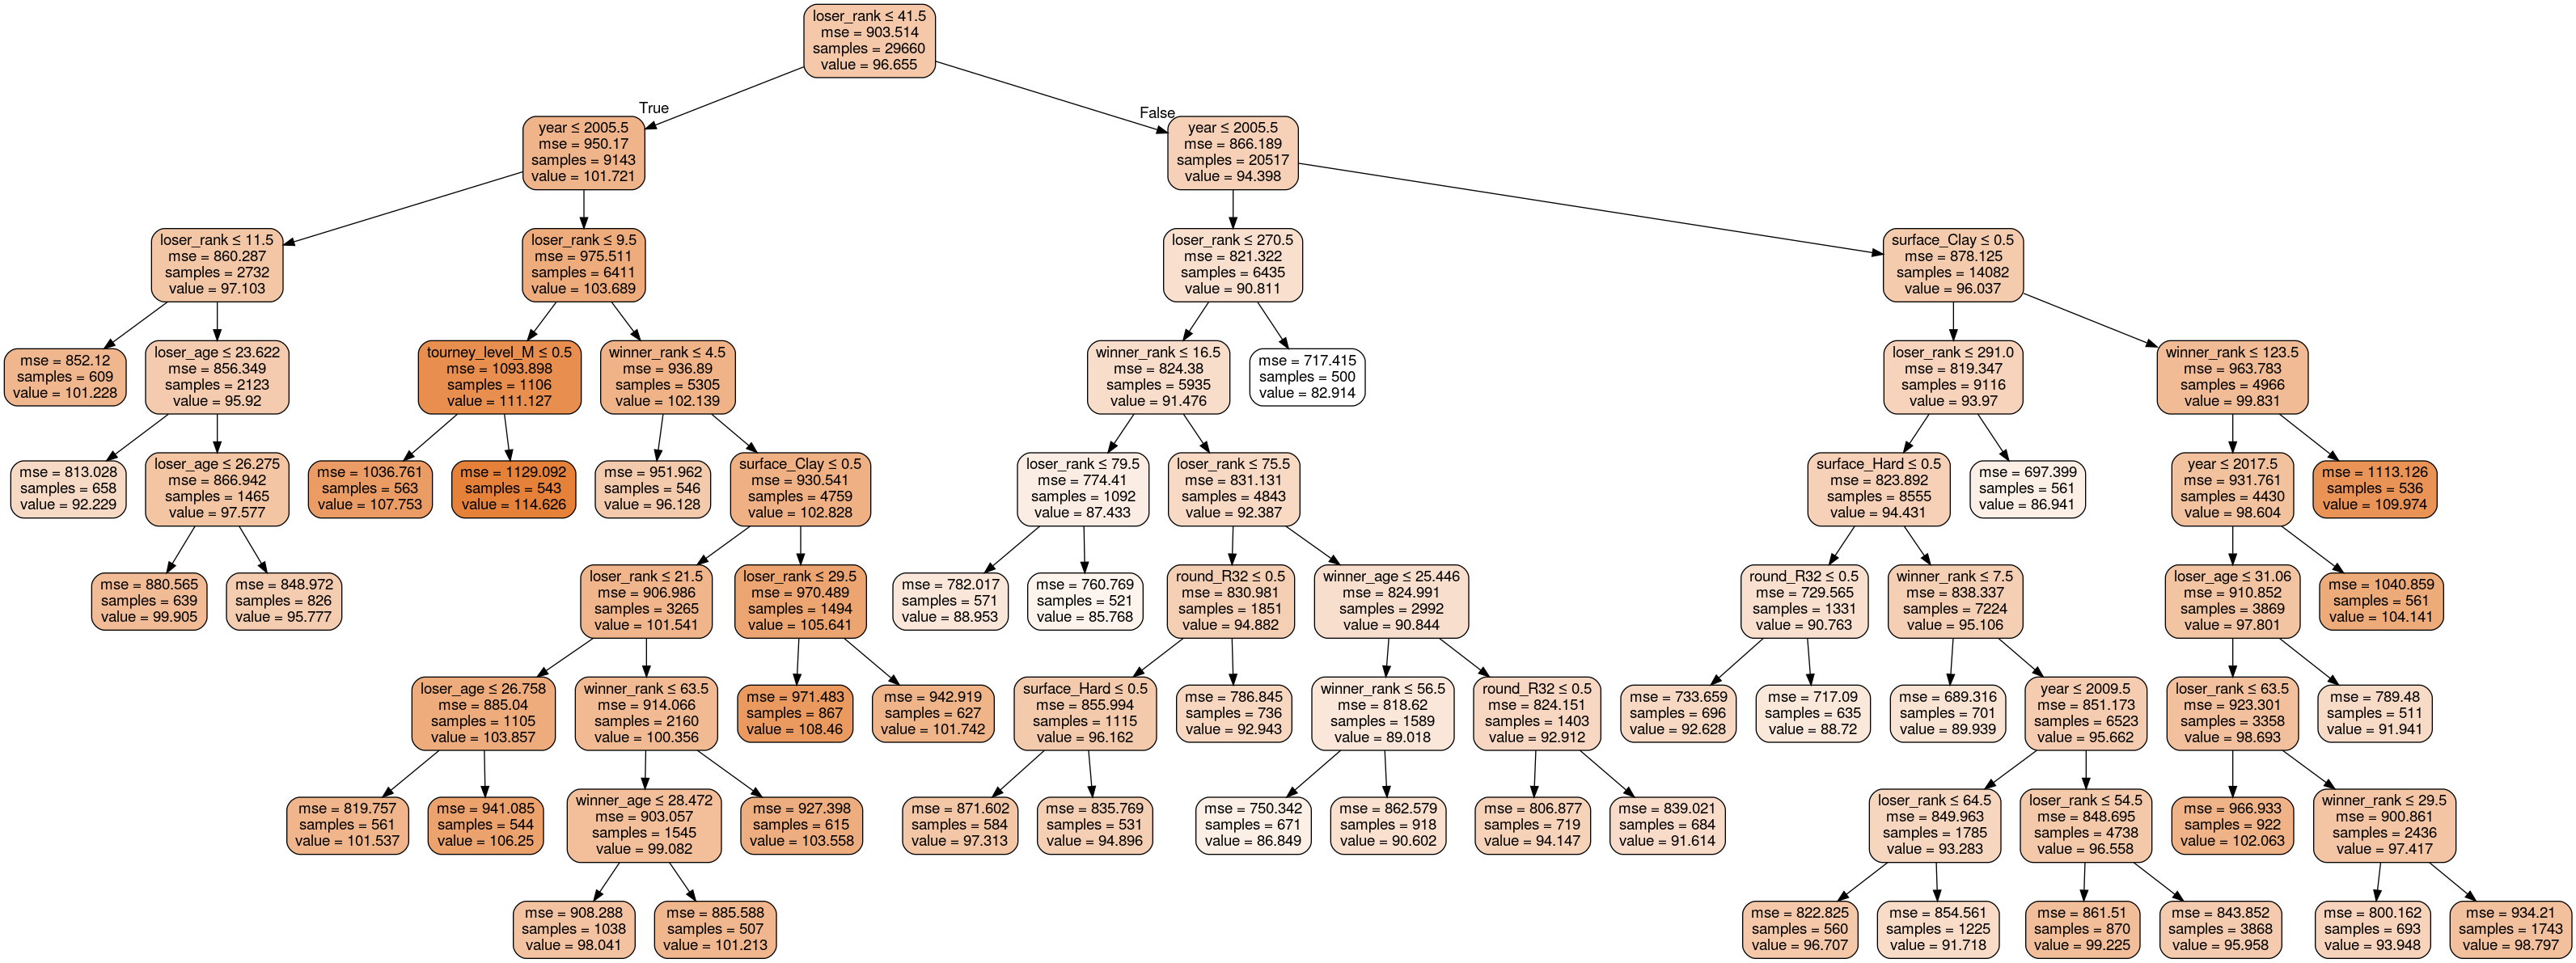

In [356]:
dot_data = StringIO()

export_graphviz(regBestTree_bo3, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
               feature_names=X_train_T_bo3.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

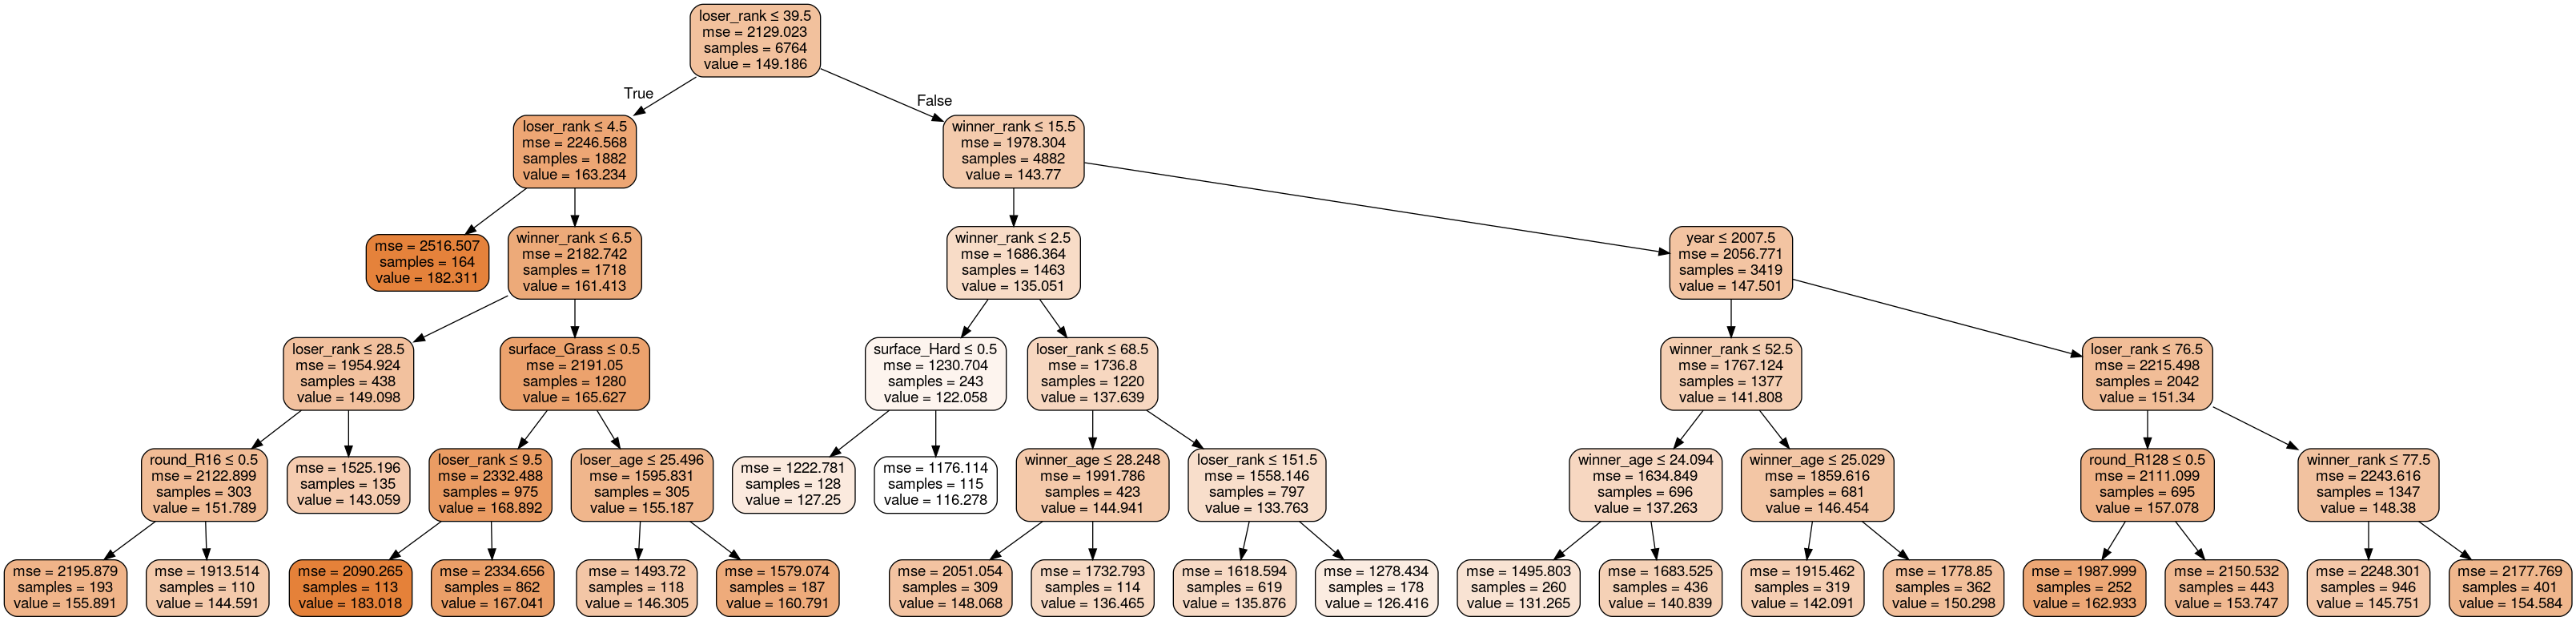

In [357]:
dot_data = StringIO()

export_graphviz(regBestTree_bo5, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
               feature_names=X_train_T_bo5.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

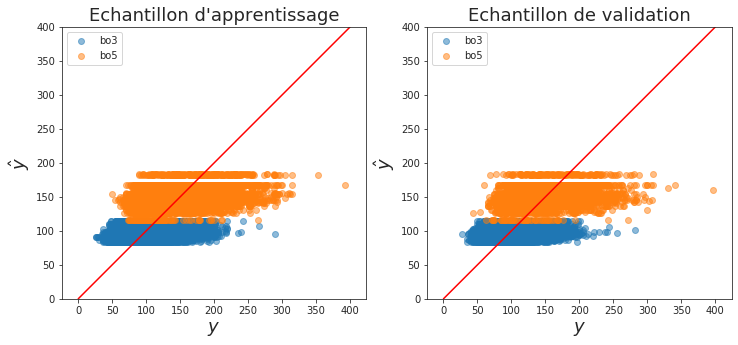

In [358]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].scatter(y_train_bo3, y_pred_train_bo3, alpha=0.5, label='bo3')
axs[0].scatter(y_train_bo5, y_pred_train_bo5, alpha=0.5, label='bo5')
axs[0].plot([0,400], [0,400], color='red')
axs[0].axis('equal')
axs[0].set_xlim((0,400))
axs[0].set_ylim((0,400))
axs[0].set_xlabel("$y$",fontsize=18)
axs[0].set_ylabel("$\hat{y}$",fontsize=18)
axs[0].legend()
axs[0].set_title("Echantillon d'apprentissage",fontsize=18)
axs[1].scatter(y_test_bo3, y_pred_test_bo3, alpha=0.5, label='bo3')
axs[1].scatter(y_test_bo5, y_pred_test_bo5, alpha=0.5, label='bo5')
axs[1].plot([0,400], [0,400], color='red')
axs[1].axis('equal')
axs[1].set_xlim((0,400))
axs[1].set_ylim((0,400))
axs[1].set_xlabel("$y$",fontsize=18)
axs[1].set_ylabel("$\hat{y}$",fontsize=18)
axs[1].legend()
axs[1].set_title("Echantillon de validation", fontsize=18)
plt.show()

## Random Forest

Nous passons maintenant aux Random Forests

In [359]:
from sklearn.ensemble import RandomForestRegressor

In [360]:
regRF_bo3 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1,)
regRF_bo5 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

RF_params = {'max_depth':[x for x in range(5,21,5)], 
                   'min_samples_leaf':[10, 100, 500],
              'max_features':['sqrt', 'log2', 'auto'],
              'bootstrap':[True, False]}

In [361]:
GSCV_RF_bo3 = GridSearchCV(regRF_bo3, RF_params, 'neg_mean_squared_error', cv=3)
GSCV_RF_bo3.fit(X_train_T_bo3, y_train_bo3)
regBestRF_bo3 = GSCV_RF_bo3.best_estimator_
print('Valeurs optimales de (max_depth, min_samples_leaf, max_features, bootstrap) : {}'.format((GSCV_RF_bo3.best_estimator_.get_params()['max_depth'], 
                                                                                               GSCV_RF_bo3.best_estimator_.get_params()['min_samples_leaf'], 
                                                                                               GSCV_RF_bo3.best_estimator_.get_params()['max_features'], 
                                                                                               GSCV_RF_bo3.best_estimator_.get_params()['bootstrap'])))
X_test_T_bo3 = harmonisation_train_test(X_train_T_bo3, X_test_T_bo3)
y_pred_train_bo3 = regBestRF_bo3.predict(X_train_T_bo3.values)
y_pred_test_bo3 = regBestRF_bo3.predict(X_test_T_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

GSCV_RF_bo5 = GridSearchCV(regRF_bo5, RF_params, 'neg_mean_squared_error', cv=3)
GSCV_RF_bo5.fit(X_train_T_bo5, y_train_bo5)
regBestRF_bo5 = GSCV_RF_bo5.best_estimator_
print('Valeurs optimales de (max_depth, min_samples_leaf, max_features, bootstrap) : {}'.format((GSCV_RF_bo5.best_estimator_.get_params()['max_depth'], 
                                                                                               GSCV_RF_bo5.best_estimator_.get_params()['min_samples_leaf'], 
                                                                                               GSCV_RF_bo5.best_estimator_.get_params()['max_features'], 
                                                                                               GSCV_RF_bo5.best_estimator_.get_params()['bootstrap'])))
X_test_T_bo5 = harmonisation_train_test(X_train_T_bo5, X_test_T_bo5)
y_pred_train_bo5 = regBestRF_bo5.predict(X_train_T_bo5.values)
y_pred_test_bo5 = regBestRF_bo5.predict(X_test_T_bo5.values)
print('Bo5:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Valeurs optimales de (max_depth, min_samples_leaf, max_features, bootstrap) : (20, 10, 'auto', True)
Bo3:
	MSE : train = 606.0080736411345 / test = 862.6042729810218
Valeurs optimales de (max_depth, min_samples_leaf, max_features, bootstrap) : (15, 10, 'sqrt', False)
Bo5:
	MSE : train = 1519.5700892098434 / test = 2017.5362842135473


Ce modèle est jusqu'à maintenant le plus performant, que ce soit sur les matchs en bo3 ou les matchs en bo5, sur l'échantillon d'apprentissage et de validation.  
  
Les hyper paramètres optimaux sont indiqués dans la sortie Python.

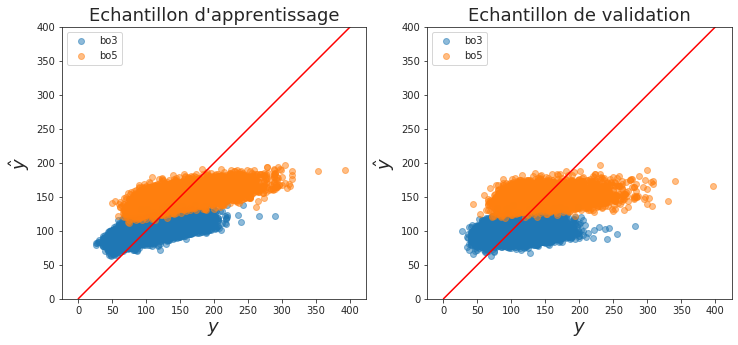

In [362]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].scatter(y_train_bo3, y_pred_train_bo3, alpha=0.5, label='bo3')
axs[0].scatter(y_train_bo5, y_pred_train_bo5, alpha=0.5, label='bo5')
axs[0].plot([0,400], [0,400], color='red')
axs[0].axis('equal')
axs[0].set_xlim((0,400))
axs[0].set_ylim((0,400))
axs[0].set_xlabel("$y$",fontsize=18)
axs[0].set_ylabel("$\hat{y}$",fontsize=18)
axs[0].legend()
axs[0].set_title("Echantillon d'apprentissage",fontsize=18)
axs[1].scatter(y_test_bo3, y_pred_test_bo3, alpha=0.5, label='bo3')
axs[1].scatter(y_test_bo5, y_pred_test_bo5, alpha=0.5, label='bo5')
axs[1].plot([0,400], [0,400], color='red')
axs[1].axis('equal')
axs[1].set_xlim((0,400))
axs[1].set_ylim((0,400))
axs[1].set_xlabel("$y$",fontsize=18)
axs[1].set_ylabel("$\hat{y}$",fontsize=18)
axs[1].legend()
axs[1].set_title("Echantillon de validation", fontsize=18)
plt.show()

## Adaboost

Le dernier modèle que nous employons est Adaboost, un algorithme de type ensemble learning (et plus exactement de la famille des Boosting Trees comme XGBoost par exemple).  
  
Dans ce type de modèle, le nombre de weak learners utilisés est une variable de contrôle de l'overfit cruciale directement lié au learning rate. Plus le learning rate diminue, plus le nombre optimal d'estimateur est élevé. L'estimateur de base que nous utiliserons reprendra les caractéristiques des arbres constituant les Random Forests précédentes.  
  
Pour optimiser les hypers paramètres d'Adaboost, nous commençons par fixer un learning rate élevé afin de trouver le nombre optimal d'estimateurs associé à ce learning rate. Puis nous essayerons différentes fonctions de pertes avant de recommencer une CrossValidation sur le nombre d'estimateurs utilisés, avec cette fois-ci un learning rate plus faible. 

In [363]:
from sklearn.ensemble import AdaBoostRegressor

In [364]:
base_estimator_bo3 = DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, max_features='sqrt')
base_estimator_bo5 = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, max_features='auto')

regAda_bo3 = AdaBoostRegressor(base_estimator=base_estimator_bo3,
                               learning_rate=0.5,
                               random_state=42)
regAda_bo5 = AdaBoostRegressor(base_estimator=base_estimator_bo5,
                               learning_rate=0.5,
                               random_state=42)

Ada_params = {'n_estimators':[50, 100, 200]}

In [365]:
GSCV_Ada_bo3 = GridSearchCV(regAda_bo3, Ada_params, 'neg_mean_squared_error', cv=3)
GSCV_Ada_bo3.fit(X_train_T_bo3, y_train_bo3)
regBestAda_bo3 = GSCV_Ada_bo3.best_estimator_
print('Valeur optimale de n_estimators : {}'.format((GSCV_Ada_bo3.best_estimator_.get_params()['n_estimators'])))
X_test_T_bo3 = harmonisation_train_test(X_train_T_bo3, X_test_T_bo3)
y_pred_train_bo3 = regBestAda_bo3.predict(X_train_T_bo3.values)
y_pred_test_bo3 = regBestAda_bo3.predict(X_test_T_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

GSCV_Ada_bo5 = GridSearchCV(regAda_bo5, Ada_params, 'neg_mean_squared_error', cv=3)
GSCV_Ada_bo5.fit(X_train_T_bo5, y_train_bo5)
regBestAda_bo5 = GSCV_Ada_bo5.best_estimator_
print('Valeur optimale de n_estimators : {}'.format((GSCV_Ada_bo5.best_estimator_.get_params()['n_estimators'])))
X_test_T_bo5 = harmonisation_train_test(X_train_T_bo5, X_test_T_bo5)
y_pred_train_bo5 = regBestAda_bo5.predict(X_train_T_bo5.values)
y_pred_test_bo5 = regBestAda_bo5.predict(X_test_T_bo5.values)
print('Bo5:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Valeur optimale de n_estimators : 50
Bo3:
	MSE : train = 842.3242808698711 / test = 940.8522778615195
Valeur optimale de n_estimators : 50
Bo5:
	MSE : train = 2049.362724965789 / test = 2228.2450748641627


Les résultats obtenus sont moins bons qu'avec la random forest, le learning rate doit être trop élevé, nous reviendrons sur ces paramètres après avoir décidé de la meilleure fonction de perte à utiliser.

In [366]:
regAda_bo3 = AdaBoostRegressor(base_estimator=base_estimator_bo3,
                               n_estimators=50,
                               learning_rate=0.5,
                               random_state=42)
regAda_bo5 = AdaBoostRegressor(base_estimator=base_estimator_bo5,
                               n_estimators=50,
                               learning_rate=0.5,
                               random_state=42)

Ada_params = {'loss':['linear', 'square', 'exponential']}

In [367]:
GSCV_Ada_bo3 = GridSearchCV(regAda_bo3, Ada_params, 'neg_mean_squared_error', cv=3)
GSCV_Ada_bo3.fit(X_train_T_bo3, y_train_bo3)
regBestAda_bo3 = GSCV_Ada_bo3.best_estimator_
print('Valeur optimale de loss : {}'.format((GSCV_Ada_bo3.best_estimator_.get_params()['loss'])))
X_test_T_bo3 = harmonisation_train_test(X_train_T_bo3, X_test_T_bo3)
y_pred_train_bo3 = regBestAda_bo3.predict(X_train_T_bo3.values)
y_pred_test_bo3 = regBestAda_bo3.predict(X_test_T_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

GSCV_Ada_bo5 = GridSearchCV(regAda_bo5, Ada_params, 'neg_mean_squared_error', cv=3)
GSCV_Ada_bo5.fit(X_train_T_bo5, y_train_bo5)
regBestAda_bo5 = GSCV_Ada_bo5.best_estimator_
print('Valeur optimale de loss : {}'.format((GSCV_Ada_bo5.best_estimator_.get_params()['loss'])))
X_test_T_bo5 = harmonisation_train_test(X_train_T_bo5, X_test_T_bo5)
y_pred_train_bo5 = regBestAda_bo5.predict(X_train_T_bo5.values)
y_pred_test_bo5 = regBestAda_bo5.predict(X_test_T_bo5.values)
print('Bo5:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Valeur optimale de loss : square
Bo3:
	MSE : train = 823.6228717519143 / test = 927.3233883268804
Valeur optimale de loss : exponential
Bo5:
	MSE : train = 2049.2577641708394 / test = 2225.324132201765


La fonction de perte à prévilégier semble être la exponential loss function pour les Bo5 et la squared error pour les Bo3.  
  
En baissant le learning rate à 0.005 nous regardons si le nombre d'arbres opimal augmente.

In [368]:
base_estimator_bo3 = DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, max_features='sqrt')
base_estimator_bo5 = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, max_features='auto')

regAda_bo3 = AdaBoostRegressor(base_estimator=base_estimator_bo3,
                               learning_rate=0.1,
                               loss='square',
                               random_state=42)
regAda_bo5 = AdaBoostRegressor(base_estimator=base_estimator_bo5,
                               learning_rate=0.005,
                               loss='exponential',
                               random_state=42)

Ada_params = {'n_estimators':[50, 100, 200]}

In [369]:
GSCV_Ada_bo3 = GridSearchCV(regAda_bo3, Ada_params, 'neg_mean_squared_error', cv=3)
GSCV_Ada_bo3.fit(X_train_T_bo3, y_train_bo3)
regBestAda_bo3 = GSCV_Ada_bo3.best_estimator_
print('Valeur optimale de n_estimators : {}'.format((GSCV_Ada_bo3.best_estimator_.get_params()['n_estimators'])))
X_test_T_bo3 = harmonisation_train_test(X_train_T_bo3, X_test_T_bo3)
y_pred_train_bo3 = regBestAda_bo3.predict(X_train_T_bo3.values)
y_pred_test_bo3 = regBestAda_bo3.predict(X_test_T_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

GSCV_Ada_bo5 = GridSearchCV(regAda_bo5, Ada_params, 'neg_mean_squared_error', cv=3)
GSCV_Ada_bo5.fit(X_train_T_bo5, y_train_bo5)
regBestAda_bo5 = GSCV_Ada_bo5.best_estimator_
print('Valeur optimale de n_estimators : {}'.format((GSCV_Ada_bo5.best_estimator_.get_params()['n_estimators'])))
X_test_T_bo5 = harmonisation_train_test(X_train_T_bo5, X_test_T_bo5)
y_pred_train_bo5 = regBestAda_bo5.predict(X_train_T_bo5.values)
y_pred_test_bo5 = regBestAda_bo5.predict(X_test_T_bo5.values)
print('Bo5:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Valeur optimale de n_estimators : 50
Bo3:
	MSE : train = 800.7065370192328 / test = 879.2413055715942
Valeur optimale de n_estimators : 100
Bo5:
	MSE : train = 1895.7402866106736 / test = 2057.7011938088453


Le nombre optimal de weak learners reste à 50 pour le modèle des bo3 tandis qu'il passe à 100 pour les bo5.

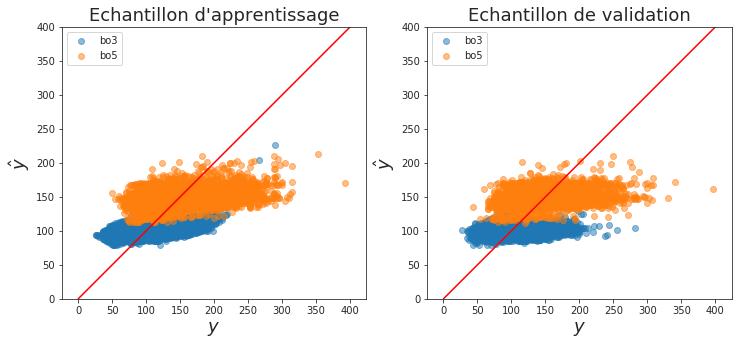

In [370]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].scatter(y_train_bo3, y_pred_train_bo3, alpha=0.5, label='bo3')
axs[0].scatter(y_train_bo5, y_pred_train_bo5, alpha=0.5, label='bo5')
axs[0].plot([0,400], [0,400], color='red')
axs[0].axis('equal')
axs[0].set_xlim((0,400))
axs[0].set_ylim((0,400))
axs[0].set_xlabel("$y$",fontsize=18)
axs[0].set_ylabel("$\hat{y}$",fontsize=18)
axs[0].legend()
axs[0].set_title("Echantillon d'apprentissage",fontsize=18)
axs[1].scatter(y_test_bo3, y_pred_test_bo3, alpha=0.5, label='bo3')
axs[1].scatter(y_test_bo5, y_pred_test_bo5, alpha=0.5, label='bo5')
axs[1].plot([0,400], [0,400], color='red')
axs[1].axis('equal')
axs[1].set_xlim((0,400))
axs[1].set_ylim((0,400))
axs[1].set_xlabel("$y$",fontsize=18)
axs[1].set_ylabel("$\hat{y}$",fontsize=18)
axs[1].legend()
axs[1].set_title("Echantillon de validation", fontsize=18)
plt.show()

# Récapitulatif des résultats

Les résultats obtenus par nos différents modèles sont rassemblés dans le tableau suivant :  

| Modèle           | Bo3              | Bo5     |
| :---------------- |:----------------------:| :---------------:|
| Régression Linéaire     | $874$ / $878$ | $2029$ / $2134$ |
| Régression Lasso     | $874$ / $878$ | $2031$ / $2132$ |
| Régression Polynomiale| $821$ / $951$ | $1942$ / $4323$ |
| Arbre de décision| $862$ / $880$ | $1945$ / $2097$ |
| Random Forest| $606$ / $862$ | $1519$ / $2017$ |
| Régression Polynomiale| $800$ / $879$ | $1895$ / $2057$ | 
  
<center>(Format : Train / Test)</center>
  
  
C'est la Random Forest qui nous donne les meilleurs résultats.

Nous sauvegardons nos bases de test et de validation sur les Bo3 et Bo5 contenant les transformations effectuées lors de la construction de nos différents estimateurs.

In [371]:
X_train_T_bo3.to_csv(PATH+'/data/X_train_T_bo3.csv')
X_train_T_bo5.to_csv(PATH+'/data/X_train_T_bo5.csv')
X_test_T_bo3.to_csv(PATH+'/data/X_test_T_bo3.csv')
X_test_T_bo5.to_csv(PATH+'/data/X_test_T_bo5.csv')
y_train_bo3.to_csv(PATH+'/data/y_train_bo3.csv')
y_test_bo3.to_csv(PATH+'/data/y_test_bo3.csv')
y_train_bo5.to_csv(PATH+'/data/y_train_bo5.csv')
y_test_bo5.to_csv(PATH+'/data/y_test_bo5.csv')

Nous passons ensuite à l'étape de création de nouvelles variables afin d'augmenter le potentiel explicatif de nos modèles.

In [372]:
X_test_T_bo5

,winner_age,winner_rank,loser_age,loser_rank,year,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,tourney_level_A,round_BR,round_ER,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF,winner_hand_L,winner_hand_R,winner_hand_U,loser_hand_L,loser_hand_R,loser_hand_U,tourney_name_Australian Open,tourney_name_Roland Garros,tourney_name_US Open,tourney_name_Wimbledon,tourney_name_sch,tourney_name_autre
22041,25.314168,142.0,24.506502,198.0,2005,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
5297,21.891855,142.0,30.228611,82.0,2000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
8657,27.129363,13.0,28.465435,43.0,2001,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
8610,21.289528,4.0,28.440794,220.0,2001,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0
46799,25.667351,172.0,26.431211,88.0,2013,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54563,30.680356,8.0,25.916496,46.0,2016,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
5301,27.545517,30.0,26.907598,91.0,2000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
56350,30.932238,35.0,35.088296,43.0,2017,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
44575,22.171116,26.0,27.268994,80.0,2013,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
